In [6]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

### Boilerplate - Spark Session & HDFS Access

In [7]:
cwd = os.getcwd()
for part in cwd.split('/'):
    if part.lower().startswith('edureka'):
        user_id = part.title()
app_name = '{0} : Linear Regression'.format(user_id)
app_name

'Edureka_121039 : Linear Regression'

In [8]:
spark = SparkSession.builder.appName(app_name).getOrCreate()
sparkContext = spark.sparkContext
sqlContext = SQLContext(sparkContext)

In [9]:
def get_hdfs_filepath(file_name):
    my_hdfs = '/user/{0}/datasets'.format(user_id.lower())
    return os.path.join(my_hdfs, file_name)

### Dataset
[Boston Housing Price dataset details](https://www.kaggle.com/c/boston-housing "Boston Housing Price Dataset")

In [10]:
BOSTON_CSV = get_hdfs_filepath('boston.csv')

### Linear Regression

In [11]:
# house_df = sqlContext.read.format('csv').options(header='true', inferschema='true').load(BOSTON_CSV)
house_df = spark.read.csv(BOSTON_CSV,inferSchema=True,header=True)
print(house_df.take(1))
print(house_df.count(), len(house_df.columns))

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0)]
(506, 14)


In [12]:
house_df.cache()
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PT: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MV: double (nullable = true)



In [13]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235608162057,8.601545086715594,0.00632,88.97619629
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778749531626,6.86035298095724,0.460000008,27.73999977
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950602312246,0.1158776754570543,0.38499999,0.870999992
RM,506,6.28463438896641,0.7026171549511354,3.561000109,8.779999733
AGE,506,68.57490120115612,28.148861532793276,2.900000095,100.0
DIS,506,3.7950426960059325,2.105710142043288,1.129600048,12.12650013
RAD,506,9.549407114624506,8.707259384239366,1,24


In [14]:
import pandas as pd
from pylab import *

In [10]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

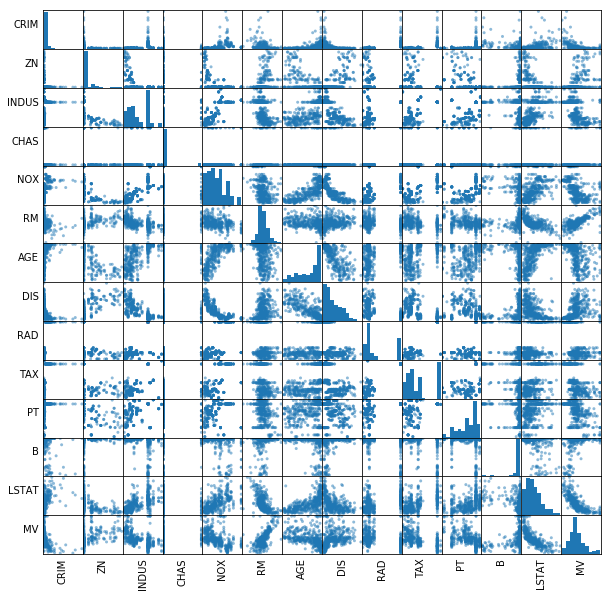

In [11]:
# call to render visuals
show()

In [12]:
print(house_df.select('CRIM').take(1)) # List of rows

[Row(CRIM=0.00632)]


In [14]:
print(house_df.select('CRIM').take(1)[0][0]) # individual row

0.00632


In [30]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MV',i))

('Correlation to MV for ', 'CRIM', -0.3883046116575088)
('Correlation to MV for ', 'ZN', 0.36044534463752903)
('Correlation to MV for ', 'INDUS', -0.48372517128143383)
('Correlation to MV for ', 'CHAS', 0.17526017775291847)
('Correlation to MV for ', 'NOX', -0.4273207763683772)
('Correlation to MV for ', 'RM', 0.695359937127267)
('Correlation to MV for ', 'AGE', -0.37695456714288667)
('Correlation to MV for ', 'DIS', 0.24992873873512172)
('Correlation to MV for ', 'RAD', -0.3816262315669168)
('Correlation to MV for ', 'TAX', -0.46853593528654536)
('Correlation to MV for ', 'PT', -0.5077867038116085)
('Correlation to MV for ', 'B', 0.3334608226834164)
('Correlation to MV for ', 'LSTAT', -0.7376627294671615)
('Correlation to MV for ', 'MV', 1.0)


In [38]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PT', 'B', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MV'])
vhouse_df.show(3)

+--------------------+-----------+
|            features|         MV|
+--------------------+-----------+
|[0.00632,18.0,2.3...|       24.0|
|[0.027310001,0.0,...|21.60000038|
|[0.02729,0.0,7.07...|34.70000076|
+--------------------+-----------+
only showing top 3 rows



In [39]:
# Validation Set - set aside training data for validation
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [40]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.0370754236864,0.0177152425124,-0.0203183694724,3.27190666252,-9.36078742047,4.45144271987,0.0,-0.810147423097,0.0,0.0,-0.816792129715,0.0104774883849,-0.506046675522]
Intercept: 20.575977094


In [41]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.061474
r2: 0.713582


In [42]:
train_df.describe().show()

+-------+-----------------+
|summary|               MV|
+-------+-----------------+
|  count|              360|
|   mean|22.30416671307222|
| stddev|9.470676617910577|
|    min|              5.0|
|    max|             50.0|
+-------+-----------------+



In [43]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MV","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|31.663475430920577|32.20000076|[0.00906,90.0,2.9...|
|28.142006877277517|       22.0|[0.01096,55.0,2.2...|
|39.377936040951454|       50.0|[0.01381,80.0,0.4...|
|31.853744304147444|31.60000038|[0.01432,100.0,1....|
|31.172112643474783|29.10000038|[0.01439,60.0,2.9...|
+------------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.747667


In [44]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.25001


In [16]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.43221190395292297, 0.2349187112448049, 0.21423734748014606, 0.18602537986458537, 0.1833878187303744, 0.18260190707359195, 0.18165035519720643, 0.18094618528502693, 0.18074496332864678, 0.18068994796918103]
+-------------------+
|          residuals|
+-------------------+
| -6.996019902115471|
| 1.2535132805952571|
| 0.5196807438700262|
| 11.773810597825786|
|-1.8902651149141754|
| -2.964267576130016|
| 10.294370831032637|
|  9.152908505317797|
| 3.7005484005969826|
| -2.799159287209463|
|   6.86561874762149|
|-0.7069490077092588|
| 5.7949790272069635|
|-0.4405927658706652|
|-3.7988193266321524|
| -4.247867535654805|
| 1.9394975627843287|
| -2.083485279408592|
| 0.8490755640388521|
|-1.4278318115834878|
+-------------------+
only showing top 20 rows



In [17]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","MV","features").show()

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|28.235595944914074|       22.0|[0.01096,55.0,2.2...|
| 29.74766248528248|35.40000153|[0.01311,90.0,1.2...|
| 16.98544151222643|18.89999962|[0.0136,75.0,4.0,...|
|31.345538812263875|31.60000038|[0.01432,100.0,1....|
|30.945902033758532|32.90000153|[0.01778,95.0,1.4...|
| 39.02009493338487|       50.0|[0.020090001,95.0...|
| 26.04348132480287|24.70000076|[0.02055,85.0,0.7...|
| 27.09150242850147|       16.5|[0.024979999,0.0,...|
| 31.43778951070596|34.70000076|[0.02729,0.0,7.07...|
| 26.42502391887756|28.70000076|[0.029850001,0.0,...|
|29.186755696747873|31.20000076|[0.03049,55.0,3.7...|
|28.591635320450823|24.10000038|[0.034449998,82.5...|
| 37.84722148197834|       48.5|[0.035100002,95.0...|
|28.049754752087125|       22.0|[0.03537,34.0,6.0...|
|25.662598920145662|24.79999924|[0.036589999,25.0...|
|22.935535830663877|20.70000

In [15]:
spark.stop()